# DVL-NAV -- Unit 770
02/11/2022
Gregory Burgess

---

1. [Import Libraries](#import-libraries)
1. [Load and Parse Data](#load-and-parse-data)
    1. [Bathymetry Data](#import-bathymetry)
    1. [Glider Flight Computer Data](#import-glider-flight-computer)
    1. [Rosbag Data](#import-rosbag-data)
    1. [Separate and Select Dives](#separate-and-select-dives)
    1. [DVL Data](#import-dvl-data)
1. [Compute Water Column Currents](#compute-water-column-currents)
1. [Compute DVL-Odometry](#compute-dvl-odometry)
1. [Multi-Factor Terrain Based Navigation](#multi-factor-terrain-based-navigation)
    1. [Plot Navigation Results](#plot-navigation-results)
    1. [Navigation Performance](#navigation-performance)
        2. [Print Performance metrics](#print_metrics)
1. [Sandbox](#sandbox)


Bin number to 20 --- why did i do this again and do i want 40 for puerto rico

dvl ensemble coordinate frame

---
<a id='import-libraries'></a>
## Import Libraries

In [164]:
import datetime
import earthpy as et
import earthpy.plot as ep
import importlib
import numpy as np
import os
import pandas as pd
import rasterio as rio
import scipy
import scipy.signal
import seaborn as sns 
import struct
import sys
import utm
import unittest
from PIL import Image
from matplotlib import pyplot as plt 
from os import listdir
from os.path import isfile, join
from scipy.spatial.transform import Rotation as R
from scipy import interpolate

# add parent directory to the path for importing modules 
sys.path.insert(1, os.path.join(sys.path[0], '..'))
sys.path.append(os.path.join(sys.path[0], '../data'))

# objects for parsing raw DVL data 
import PathfinderDVL
import PathfinderEnsemble
import PathfinderTimeSeries

# objects for estimating ocean current velocities
import VelocityShearPropagation

# objects for controlling thruster to minimize transport cost 
import AdaptiveVelocityController

# objects for parsing flight and science computer log files
import SlocumFlightController
import SlocumScienceController
import dvl_plotter
import BathymetryMap
import MultiFactorTAN

# data for parsing seafloor bathymetry
import bathy_meta_data
sns.set()


import warnings
warnings.simplefilter('ignore')

def reload_modules():
    importlib.reload(PathfinderDVL)
    importlib.reload(PathfinderEnsemble)
    importlib.reload(PathfinderTimeSeries)
    importlib.reload(VelocityShearPropagation)
    importlib.reload(AdaptiveVelocityController)
    importlib.reload(SlocumFlightController)
    importlib.reload(SlocumScienceController)
    importlib.reload(dvl_plotter)
    importlib.reload(bathy_meta_data)
    importlib.reload(BathymetryMap)
    importlib.reload(MultiFactorTAN)
print('Done!')

#TODO
#pip3 install utm threw error --> is this code all designed for python2???

Done!


In [98]:
#filepath = '/home/gburgess/dvl-nav/data/field_data/buzz_bay/dec_15/'
filepath = '/home/gburgess/dvl-nav/data/field_data/puerto_rico/mar8/'

---
<a id='load-and-parse-data'></a>
## Load and Parse Data
<a id='import-bathymetry'></a>
### Bathymetry Data

In [ ]:
# #TODO
# reload_modules()
# #Grid_res_num should always be 10 to represent original resolution of the bathymetry chart. Then, the Minimum spatial resolution will be 5m
# #directory = "/mnt/c/Users/User/Dropbox (MIT)/Kolumbo cruise 2019/zduguid/dbd-parsed/sentinel_2019-Nov/
# #10m resolution
# #bathy_df = pd.read_csv('/mnt/c/Users/User/Dropbox (MIT)/Kolumbo cruise 2019/zduguid/bathy/sensitivity_tests/Kolumbo-1.csv')
# bathy_df = pd.read_csv('/home/gburgess/dvl-nav/data/field_data/kolumbo/bathy/Kolumbo-1.csv')
# grid_res_num = 10
# # map_var_resolution = '10m'

# #20m resolution
# #bathy_df_var = pd.read_csv('/mnt/c/Users/User/Dropbox (MIT)/Kolumbo cruise 2019/zduguid/bathy/sensitivity_tests/Kolumbo-2.csv')
# bathy_df_var = pd.read_csv('/home/gburgess/dvl-nav/data/field_data/kolumbo/bathy/Kolumbo-2.csv')
# map_var_resolution = '20m'
# # grid_res_num = 20

<a id='import-glider-flight-computer'></a>
### Glider Flight Computer Data

In [126]:
reload_modules()
directory = filepath+'dbd_parsed/'
ts_flight = SlocumFlightController.SlocumFlightController.from_directory(directory, save=False, verbose=False)
ts_flight.df.to_csv('DBD_MAR8.csv', sep=',' , index=False)
# ts_flight.df.to_csv(filepath+'ts_flight.csv', sep=',' , index=False)
#ts_flight.df.head()

>> Parsing folder of ASC Files
>> Finished Parsing!


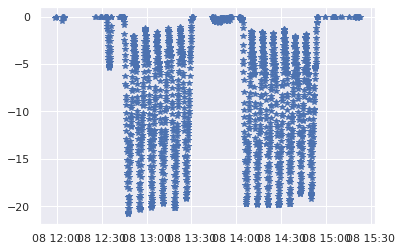

In [125]:
plt.figure()
#plt.plot(ts_flight.df.m_pitch*180/3.14)
plt.plot(ts_flight.df.m_depth*-1, '*')

<a id='import-rosbag-data'></a>
### Rosbag Data

In [45]:
# CTD Sensor
#ctd_df = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'ctd-data.csv')

# IMU Sensor
# ahrs_df = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-spartonm2-ahrs.csv')

# # DVL Sensor
# dvl_df        = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-dvl.csv')
# dvl_pd0_df    = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-pd0.csv')
# dvl_ranges_df = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-ranges.csv')
# dvl_raw_df    = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-instrument-raw.csv')

# EXTCTL - GLider 
# m_lon_df        = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_lon.csv')
# m_lat_df        = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_lat.csv')
# m_gps_lon_df    = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_gps_lon.csv')
# m_gps_lat_df    = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_gps_lat.csv')
# m_depth_df      = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_depth.csv')
# m_pitch_df      = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_pitch.csv')
# m_roll_df       = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_roll.csv')
# m_altitude_df   = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_altitude.csv')
# m_alt_status_df = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_altimeter_status.csv')

# Micron Sonar



<a id='separate-and-select-dives'></a>
### Separate and Select Dives

In [127]:
ctd_df = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'ctd-data.csv')
#TODO find a better way than just the minimum
print('Zeroing out CTD Data. Minimum Depth: ' + str(min(ctd_df.depth)))
ctd_df.depth = ctd_df.depth - min(ctd_df.depth)


Zeroing out CTD Data. Minimum Depth: 3.2799999713897705


In [128]:
# Use CTD to determine start and end points of dives
dive_dic = {}
dive_dic['dive1'] = [0]
count = 0
for i in range(1,len(ctd_df.Time)):
    dt = ctd_df.Time[i] - ctd_df.Time[i-1]
    if dt > 5.0:
        count += 1
        dive_dic['dive'+str(count)].append(i-1)
        dive_dic['dive'+str(count+1)] = [i]

# Pop off last entry (will only have one idx)
for key in dive_dic:
    if len(dive_dic[key]) < 2:
        last = key
dive_dic.pop(last)

# Create DateTime Column to make it easier to read
#ctd_df['Time'] = pd.to_datetime(ctd_df['header.stamp.secs'], unit='s')
ctd_df['Time_easy'] = (ctd_df['Time'] - ctd_df.Time[0])/60

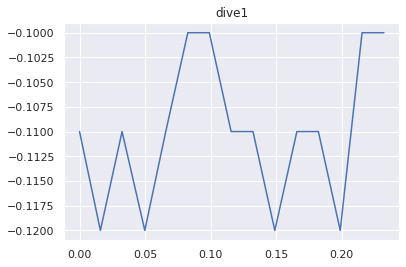

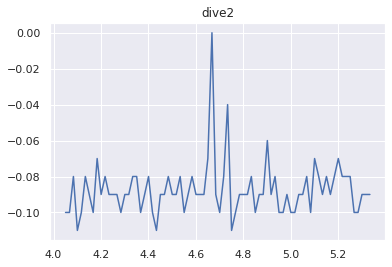

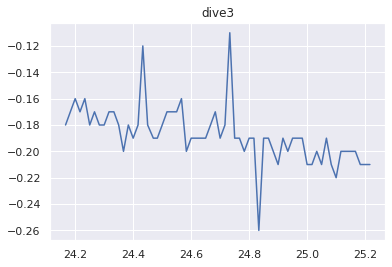

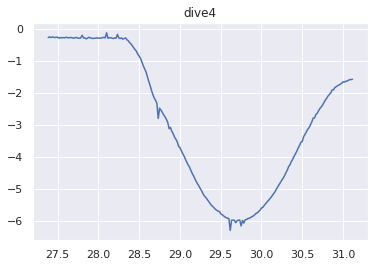

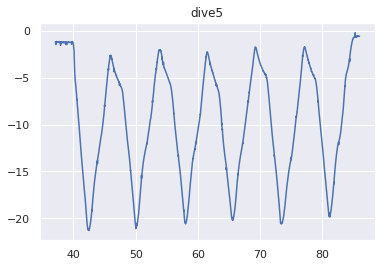

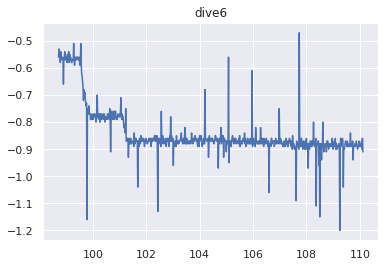

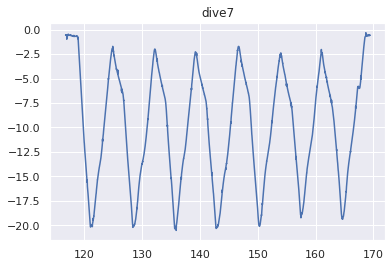

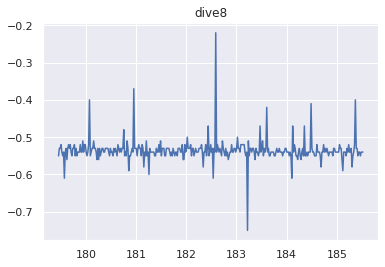

In [129]:
for key in dive_dic:
    plt.figure()
    plt.plot(ctd_df.Time_easy[dive_dic[key][0]:dive_dic[key][1]], ctd_df.depth[dive_dic[key][0]:dive_dic[key][1]]*-1)
    plt.title(key)

### Select Dive

In [130]:
selected_dive = 'dive5'

In [131]:
ctd_start = ctd_df.Time[dive_dic[selected_dive][0]]
ctd_end = ctd_df.Time[dive_dic[selected_dive][1]]
print(ctd_start, ctd_end)

time_zone_shift = 3600*5

start_t = datetime.datetime.fromtimestamp(ctd_start+time_zone_shift)
end_t   = datetime.datetime.fromtimestamp(ctd_end+time_zone_shift)
dur     = end_t - start_t 
print(start_t, end_t)

df_dbd  = ts_flight.df[str(start_t):str(end_t)].copy()

1646739770.132682 1646742705.3290122
2022-03-08 12:42:50.132682 2022-03-08 13:31:45.329012


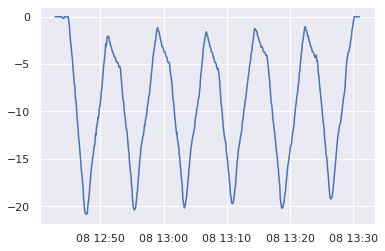

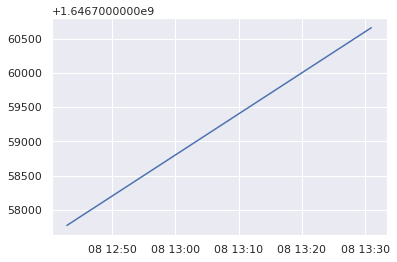

In [132]:
plt.figure()
plt.plot(df_dbd.m_depth*-1)

plt.figure()
# plt.plot(ts.df.time)
plt.plot(df_dbd.time)


In [133]:
# DVL Sensor
dvl_df        = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-dvl.csv')
dvl_pd0_df    = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-pd0.csv')
dvl_ranges_df = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-ranges.csv')
dvl_raw_df    = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'devices-dvl-instrument-raw.csv')



In [134]:
dvl_raw_df.head()
dvl_raw_df_new = dvl_raw_df.set_index('Time')


In [135]:

start_dvl = dvl_raw_df_new.index.get_loc(ctd_start, method='nearest')
end_dvl = dvl_raw_df_new.index.get_loc(ctd_end, method='nearest')
print(start_dvl, end_dvl)

2292 5227


<a id='import-dvl-data'></a>
### DVL Data

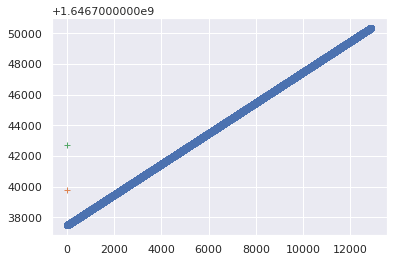

In [136]:
plt.figure()
plt.plot(dvl_raw_df.Time, 'o')
plt.plot(ctd_start, '+')
plt.plot(ctd_end, '+')

In [165]:
# Interpolate AHRS and CTD data onto DVL timestamp. Simplest solution for post-processing.
# TODO consider how to trasnfer this to live application

ahrs_df = pd.read_csv(filepath + 'rosbags/rosbag_output/' + 'devices-spartonm2-ahrs.csv')
# ahrs_df.head()
f_roll = scipy.interpolate.interp1d(ahrs_df.Time, ahrs_df.roll, 'nearest')
f_pitch = scipy.interpolate.interp1d(ahrs_df.Time, ahrs_df.pitch, 'nearest')
f_heading = scipy.interpolate.interp1d(ahrs_df.Time, ahrs_df['compass.heading'], 'nearest')

# CTD
f_depth = scipy.interpolate.interp1d(ctd_df.Time, ctd_df.depth, 'linear')
f_temp = scipy.interpolate.interp1d(ctd_df.Time, ctd_df.temperature, 'linear')
f_cond = scipy.interpolate.interp1d(ctd_df.Time, ctd_df.conductivity, 'linear')


In [166]:
reload_modules()
# Initialize Timseries object
ts = PathfinderTimeSeries.PathfinderTimeSeries()
prev_ensemble = None
error_count = 0
for i in range(start_dvl,end_dvl):
# for i in range(4,len(dvl_raw_df.data)):
# for i in range(start_dvl, end_dvl):
        ros_timestamp = dvl_raw_df.Time[i]
        roll = f_roll(ros_timestamp)
        pitch = f_pitch(ros_timestamp)
        heading = f_heading(ros_timestamp)
        depth = f_depth(ros_timestamp)
        temp = f_temp(ros_timestamp)
        cond = f_cond(ros_timestamp)

        ensemble_raw = dvl_raw_df.data[i][2:-1]
        ensemble_bytes = ensemble_raw.encode().decode('unicode_escape').encode("raw_unicode_escape")
        ensemble = PathfinderEnsemble.PathfinderEnsemble(ensemble_bytes, prev_ensemble, gps_fix=None, ros_time=ros_timestamp, \
                                                         ext_roll=roll, ext_pitch=pitch, ext_heading=heading, \
                                                         ext_depth=depth, ext_temp=temp, ext_cond=cond)
        ts.add_ensemble(ensemble)
        prev_ensemble = ensemble
    # try:
    #     ros_timestamp = dvl_raw_df.Time[i]
    #     roll = f_roll(ros_timestamp)
    #     pitch = f_pitch(ros_timestamp)
    #     heading = f_pitch(ros_timestamp)

    #     ensemble_raw = dvl_raw_df.data[i][2:-1]
    #     ensemble_bytes = ensemble_raw.encode().decode('unicode_escape').encode("raw_unicode_escape")
    #     ensemble = PathfinderEnsemble.PathfinderEnsemble(ensemble_bytes, prev_ensemble, gps_fix=None, ros_time=ros_timestamp, \
    #                                                      ext_roll=roll, ext_pitch=pitch, ext_heading=heading)
    #     ts.add_ensemble(ensemble)
    #     prev_ensemble = ensemble
    # except:
    #     error_count += 1
    #     continue
ts.to_dataframe()
print('Error Count: ' + str(error_count))

Error Count: 0


In [170]:
print(ts.df.columns)

Index(['time', 'system_configuration', 'num_beams', 'num_bins',
       'pings_per_ensemble', 'depth_bin_length', 'blanking_distance',
       'low_correlation_threshold', 'percent_good_minimum',
       'error_velocity_threshold',
       ...
       'btm_beam2_range', 'btm_beam3_range', 'btm_beam0_velocity',
       'btm_beam1_velocity', 'btm_beam2_velocity', 'btm_beam3_velocity',
       'btm_beam0_rssi', 'btm_beam1_rssi', 'btm_beam2_rssi', 'btm_beam3_rssi'],
      dtype='object', length=174)


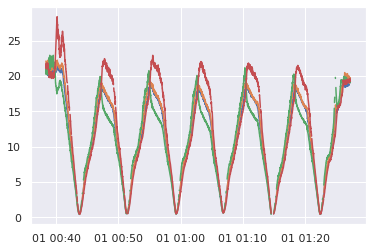

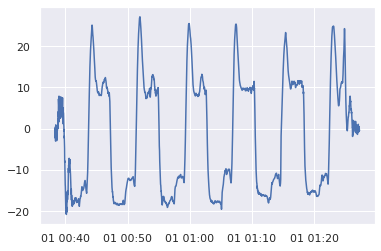

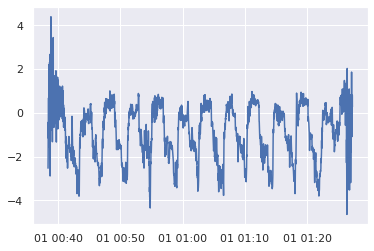

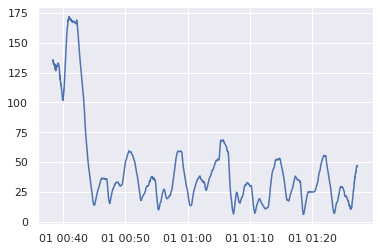

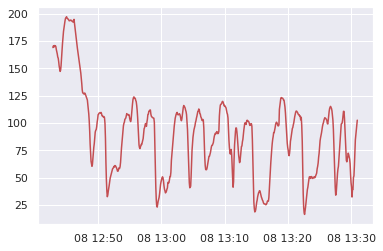

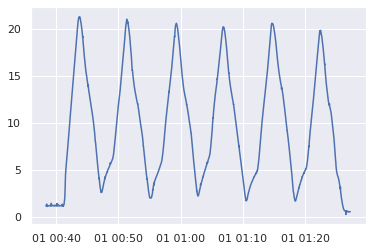

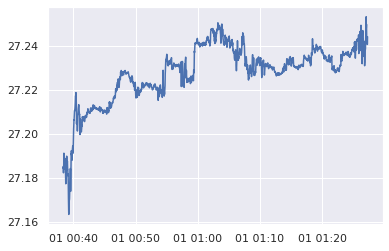

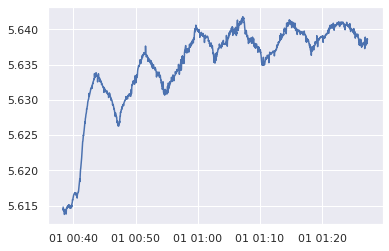

In [167]:
ts.df.head()
plt.figure()
plt.plot(ts.df.btm_beam0_range)
plt.plot(ts.df.btm_beam1_range)
plt.plot(ts.df.btm_beam2_range)
plt.plot(ts.df.btm_beam3_range)

plt.figure()
plt.plot(ts.df.ahrs_pitch)

plt.figure()
plt.plot(ts.df.ahrs_roll)

plt.figure()
plt.plot(ts.df.ahrs_heading)
plt.figure()
plt.plot(df_dbd.m_heading * 180/3.14, 'r')

plt.figure()
plt.plot(ts.df.ctd_depth)

plt.figure()
plt.plot(ts.df.ctd_temp)

plt.figure()
plt.plot(ts.df.ctd_cond)

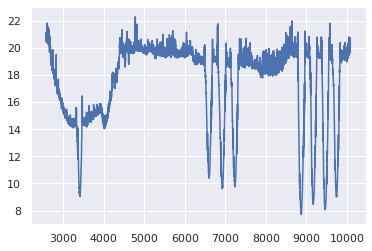

In [57]:
dvl_df.head()
plt.figure()
plt.plot(dvl_df.altitude)

In [75]:
# TIME ANALYSIS
ts.df.head()
dvl_raw_df.head()


print(datetime.datetime.fromtimestamp(ts.df.time[0]))
print(datetime.datetime.fromtimestamp(dvl_raw_df.Time[0]))


2004-01-01 01:22:45.000038
2022-03-06 22:09:30.848259


---
<a id='compute-water-column-currents'></a>
## Compute Water Column Currents


> Finished Estimating Water Column Currents!
Water Column (depth=80) 
|z =  0| V[   0,   1,   0]
|z =  1| V[----,----,----]
|z =  2| V[----,----,----]
|z =  3| V[----,----,----]
|z =  4| V[----,----,----]
|z =  5| V[----,----,----]
|z =  6| V[   0,   1,   0]
|z =  7| V[----,----,----]
|z =  8| V[   0,   0,   0]
|z =  9| V[----,----,----]
|z = 10| V[   0,   0,   0]
|z = 11| V[----,----,----]
|z = 12| V[   0,   0,   0]
|z = 13| V[----,----,----]
|z = 14| V[   0,   0,   0]
|z = 15| V[----,----,----]
|z = 16| V[   0,   1,   0]
|z = 17| V[----,----,----]
|z = 18| V[   0,   1,   0]
|z = 19| V[----,----,----]
|z = 20| V[   3,   9,   0]
|z = 21| V[----,----,----]
|z = 22| V[----,----,----]
|z = 23| V[----,----,----]
|z = 24| V[----,----,----]
|z = 25| V[----,----,----]
|z = 26| V[----,----,----]
|z = 27| V[----,----,----]
|z = 28| V[----,----,----]
|z = 29| V[----,----,----]
|z = 30| V[----,----,----]
|z = 31| V[----,----,----]
|z = 32| V[----,----,----]
|z = 33| V[----,----,----]
|z = 34| V[-

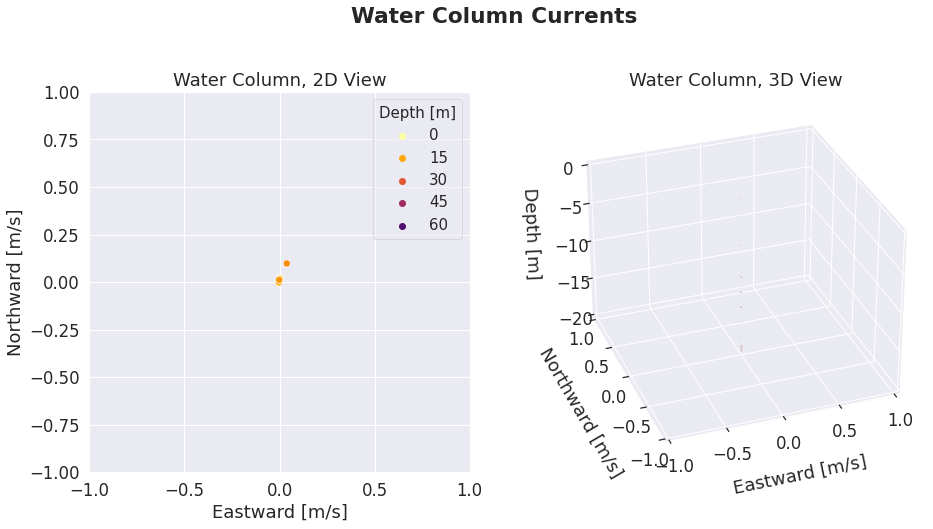

In [60]:
reload_modules()

# tuning parameters for working with DVL data 
#TODO confirm one way or another on pitch bias
pitch_bias           = 8
#pitch_bias           =  8    # [deg]   mounting pitch bias for the sonar
start_filter         =  2    # [bin #] avoid using the first number of bins
end_filter           =  2    # [bin #] avoid using the last number of bins 
voc_mag_filter       =  1.0  # [m/s]   filter out ocean current 
voc_delta_mag_filter =  0.5  # [m/s]   filter out deltas between layers
near_surface_filter  = 10    # [m]     ignore Vtw when near surface 

# constants
DEG_TO_RAD = np.pi/180

# determine DVL parameters 
bin_len      = ts.df.depth_bin_length[0]
bin0_dist    = ts.df.bin0_distance[0]
bin_len      = np.cos(pitch_bias*DEG_TO_RAD)*bin_len
bin0_dist    = np.cos(pitch_bias*DEG_TO_RAD)*bin0_dist
max_range    = 40
# max_range    = 80
max_depth    = int(np.max(ts.df.depth)+80)
x_beam       = 0
y_beam       = 1

# intialize water column
water_column = VelocityShearPropagation.WaterColumn(
    bin_len=bin_len, 
    bin0_dist=bin0_dist,
    max_depth=max_depth,
    start_filter=start_filter,
    end_filter=end_filter,
    voc_mag_filter=voc_mag_filter,
    voc_delta_mag_filter=voc_delta_mag_filter,
)

# iterate over the DVL ensembles 
for t in range(len(ts.df)):

    # only use Vtw from pressure sensor when submerged 
    depth = ts.df.depth[t]
    pitch = ts.df.pitch[t]
    roll  = ts.df.roll[t]
    if depth > near_surface_filter:
        vtw_u = ts.df.rel_vel_pressure_u[t]
        vtw_v = ts.df.rel_vel_pressure_v[t]
        
    # otherwise use the DVL to estimate the Vtw at the surface
    else:
        vtw_u = ts.df.rel_vel_dvl_u[t]
        vtw_v = ts.df.rel_vel_dvl_v[t]
    
    # extract Voc reference from bottom track velocity when available
    if not np.isnan(ts.df.abs_vel_btm_u[t]):
        vog_u = ts.df.abs_vel_btm_u[t]
        vog_v = ts.df.abs_vel_btm_v[t]
        voc_u = vog_u - vtw_u
        voc_v = vog_v - vtw_v
        voc_ref = VelocityShearPropagation.OceanCurrent(voc_u, voc_v, 0)
    else:
        voc_ref = VelocityShearPropagation.OceanCurrent()
        
    # add shear nodes for each DVL depth bin that meet the filter criteria
    num_good_vel_bins = ts.df.num_good_vel_bins[t]
    if num_good_vel_bins > start_filter+end_filter:        
        
        # determine if glider ascending or descending
        delta_z = ts.df.delta_z[t]
        if delta_z > 0:
            direction = 'descending'
        else:
            direction = 'ascending'

        # build list of velocity shears to add as ShearNode to water column
        delta_voc_u = []
        delta_voc_v = []

        # add all valid DVL bins to the shear list 
        #   + filtering of DVL bins will occur in the `add_shear_node` call
        for bin_num in range(int(num_good_vel_bins)):

            # retrieve the shear list from the DVL data 
            x_var = ts.get_profile_var_name('velocity', bin_num, x_beam)
            y_var = ts.get_profile_var_name('velocity', bin_num, y_beam)
            dvl_x = ts.df[x_var][t]
            dvl_y = ts.df[y_var][t]

            # compute delta between dead-reckoned through-water velocity & DVL
            delta_voc_u.append(vtw_u - (-dvl_x))
            delta_voc_v.append(vtw_v - (-dvl_y))

        shear_list = [VelocityShearPropagation.OceanCurrent(
                        delta_voc_u[i], 
                        delta_voc_v[i], 
                        0) 
                      for i in range(len(delta_voc_u))]

        # add shear node to the water column with shear list information 
        if len(shear_list):
            water_column.add_shear_node(
                z_true=depth,
                t=t,
                shear_list=shear_list,
                voc_ref=voc_ref,
                direction=direction,
                pitch=pitch,
                roll=roll,
            )

    # add voc_ref measurement to the water column even if shear list is empty  
    elif not voc_ref.is_none():
        water_column.add_shear_node(
            z_true=depth,
            t=t,
            shear_list=[],
            voc_ref=voc_ref,
            direction=direction,
            pitch=pitch,
            roll=roll,
        )
        
voc_u_list,voc_v_list,voc_w_list, z_list = water_column.compute_averages()
print("> Finished Estimating Water Column Currents!")
print(water_column.averages_to_str())
dvl_plotter.plot_water_column_currents(voc_u_list, voc_v_list, voc_w_list, z_list, save_name='tmp-water-column.png')

---
<a id='compute-dvl-odometry'></a>
## Compute DVL-Odometry

In [65]:
# How long (in mins) will algorithm accept ocean current estimates i.e. forgetting factor
ocean_current_time_filter = 12.5 # mins
MIN_NUM_NODES = 12
    
# initialize list for new odometry
rel_pos_x = [0]
rel_pos_y = [0]
rel_pos_z = [0]
delta_x_list = [0]
delta_y_list = [0]



vel_list_x = []
vel_list_y = []
u_list     = []
v_list     = []
# set flag for setting GPS updates
flag_gps_fix_at_surface = False 


#extract the relevant portion of the glider flight computer
start_t = datetime.datetime.fromtimestamp(ts.df.time[0])
end_t   = datetime.datetime.fromtimestamp(ts.df.time[-1])
dur     = end_t - start_t 
df_dbd  = ts_flight.df[str(start_t):str(end_t)].copy()

# extract start_t position "origin" from the glider flight data 
for t in range(len(df_dbd)):
    if not np.isnan(df_dbd.m_x_lmc[t]):
        dbd_origin_x = df_dbd.m_x_lmc[t]
        dbd_origin_y = df_dbd.m_y_lmc[t]
        break

# iterate through the dive file to update odometry
for t in range(1,len(ts.df)):
    time    = ts.df.time[t]
    prev_x  = rel_pos_x[-1]
    prev_y  = rel_pos_y[-1]
    delta_t = ts.df.delta_t[t]
    depth   = ts.df.depth[t]
    
    # only use Vtw from pressure sensor when submerged 
    depth = ts.df.depth[t]
    if depth > near_surface_filter:
        vtw_u = ts.df.rel_vel_pressure_u[t]
        vtw_v = ts.df.rel_vel_pressure_v[t]
        flag_gps_fix_at_surface = False
    # otherwise use the DVL to estimate the Vtw at the surface
    else:
        vtw_u = ts.df.rel_vel_dvl_u[t]
        vtw_v = ts.df.rel_vel_dvl_v[t]
    
    # retrieve over ground velocity from DVL in bottom track 
    vog_u = ts.df.abs_vel_btm_u[t]
    vog_v = ts.df.abs_vel_btm_v[t]
    #################################################################
    # retrieve ocean current estimate from water column 
    good_node_list = []
    count = 0
    cum_voc_u = 0
    cum_voc_v = 0
    # Extract all shear nodes at current depth
    wc_depth = water_column.get_wc_bin(depth)
    node_list = water_column.get_voc_at_depth(wc_depth)

    #Iterate through shear nodes at depth
    for shear_node in node_list:
        voc = shear_node.voc
        if not(voc.is_none()):
            # filter out large values when computing averages
            if voc.mag < voc_mag_filter:
                good_node_list.append(shear_node)
    ####################################################################
    if (len(good_node_list) > 0):
            for i in range(len(good_node_list)):
                if i == 0:
                    count += 1
                    cum_voc_u += good_node_list[0].voc.u
                    cum_voc_v += good_node_list[0].voc.v
                elif (i <= MIN_NUM_NODES):
                    count += 1
                    cum_voc_u += good_node_list[i].voc.u
                    cum_voc_v += good_node_list[i].voc.v
                else: 
                    time_between_current_estimates = good_node_list[i].t - good_node_list[0].t
                    if time_between_current_estimates > (ocean_current_time_filter*60):
                        count += 1 
                        cum_voc_u += good_node_list[i].voc.u
                        cum_voc_v += good_node_list[i].voc.v
            #voc_avg = OceanCurrent(cum_voc_u/count, cum_voc_v/count, 0)
            voc_u = cum_voc_u/count
            voc_v = cum_voc_v/count
            u_list.append(voc_u)
            v_list.append(voc_v)             
    else:
        voc_u = np.nan
        voc_v = np.nan
        u_list.append(voc_u)
        v_list.append(voc_v)

    #################################################################
    # initialize delta values to zero
    delta_x, delta_y = 0,0
    
    # CASE 1: use bottom track overground velocity if available
    if (not np.isnan(vog_u)):
        delta_x = vog_u*delta_t
        delta_y = vog_v*delta_t
        vel_list_x.append(vog_u)
        vel_list_y.append(vog_v)
    
    # CASE 2: use through water velocity and ocean current estimate if available
    elif (not np.isnan(vtw_u)) and (not np.isnan(voc_u)):
            delta_x = (vtw_u + voc_u)*delta_t
            delta_y = (vtw_v + voc_v)*delta_t
            vel_list_x.append(vtw_u + voc_u)
            vel_list_y.append(vtw_v + voc_v)
    # CASE 3: use through water velocity if available
    elif (not np.isnan(vtw_u)):
            delta_x = vtw_u*delta_t
            delta_y = vtw_v*delta_t
            vel_list_x.append(vtw_u)
            vel_list_y.append(vtw_v)
    # CASE 4: use ocean current estimate if available
    elif (not np.isnan(voc_u)):
            delta_x = voc_u*delta_t
            delta_y = voc_v*delta_t
            vel_list_x.append(voc_u)
            vel_list_y.append(voc_v)

    # set current position to DVL odometry result 
    cur_x = delta_x + prev_x
    cur_y = delta_y + prev_y
    
    # override current position if GPS fix is given 
    if depth < near_surface_filter:
        cur_time = datetime.datetime.fromtimestamp(time)
        cur_dbd  = df_dbd[str(cur_time):].copy()
        if (len(cur_dbd.m_gps_x_lmc) != 0):
            if not np.isnan(cur_dbd.m_gps_x_lmc[0]):
                cur_x = cur_dbd.m_gps_x_lmc[0] - dbd_origin_x
                cur_y = cur_dbd.m_gps_y_lmc[0] - dbd_origin_y
                flag_gps_fix_at_surface = True
                
                vel_list_x.append(cur_dbd.m_vx_lmc[0])
                vel_list_y.append(cur_dbd.m_vy_lmc[0])
    
    # update the odometry list of positions
    rel_pos_x.append(cur_x)
    rel_pos_y.append(cur_y)
    rel_pos_z.append(depth)
    delta_x_list.append(delta_x)
    delta_y_list.append(delta_y)
    
    

# rel_pos_x_noBL = rel_pos_x
# rel_pos_y_noBL = rel_pos_y
# add new odomety to the data frame
ts.df['rel_pos_x'] = rel_pos_x
ts.df['rel_pos_y'] = rel_pos_y
ts.df['rel_pos_z'] = rel_pos_z
ts.df['delta_x']   = delta_x_list
ts.df['delta_y']   = delta_y_list

print("> Finished Calculating Odometry!")

> Finished Calculating Odometry!


---
## Plot Navigation Results 

Text(0.5, 1.0, 'abs_vel_btm_v')

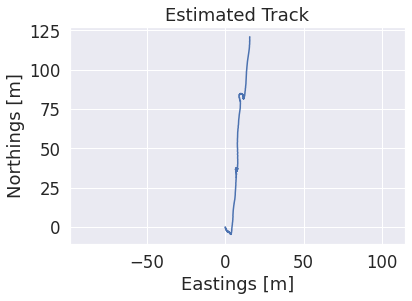

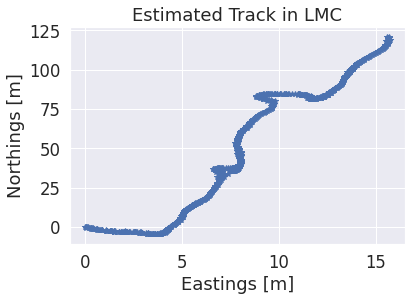

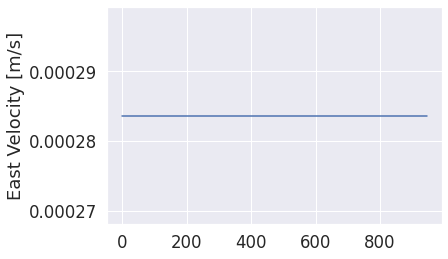

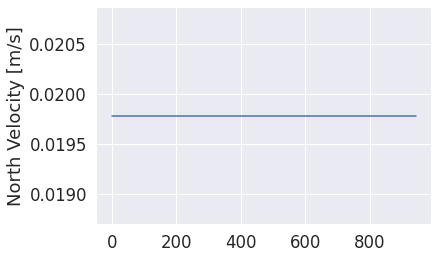

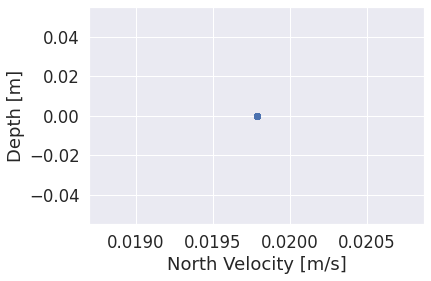

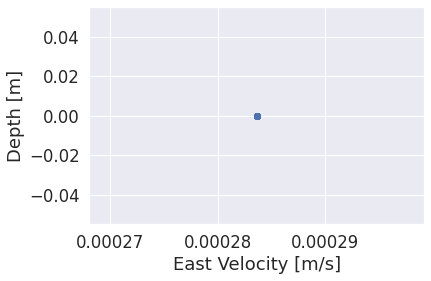

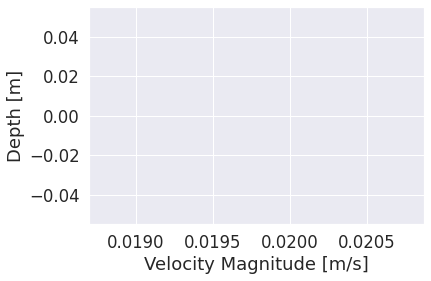

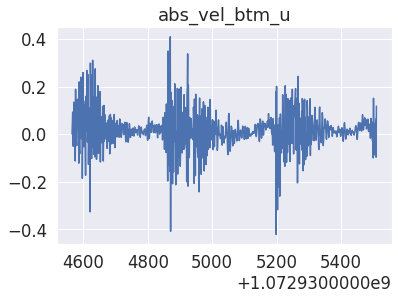

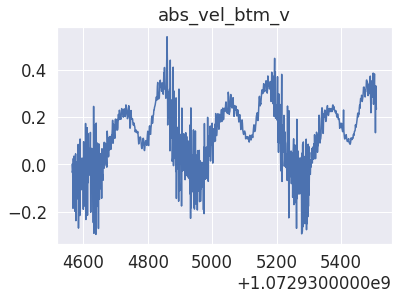

In [67]:

plt.figure()
plt.plot(ts.df.rel_pos_x, ts.df.rel_pos_y)
#plt.plot(rel_pos_x_noBL, rel_pos_y_noBL)
plt.title('Estimated Track')
plt.axis('equal')
#plt.axis([-100, 350, -100, 800])
plt.xlabel('Eastings [m]')
plt.ylabel('Northings [m]')
#plt.plot(ts.df.rel_pos_x[num_bottom_lock_to_init], ts.df.rel_pos_y[num_bottom_lock_to_init], '+')
#plt.legend(['with bottom-lock', 'no bottom-lock'], loc='lower left', fontsize='xx-small')

plt.figure()
plt.plot(ts.df.rel_pos_x, ts.df.rel_pos_y, '*')
plt.title('Estimated Track in LMC')
plt.xlabel('Eastings [m]')
plt.ylabel('Northings [m]')
#plt.plot(rel_pos_x_noBL, rel_pos_y_noBL, '*')
#plt.plot(ts.df.rel_pos_x[num_bottom_lock_to_init], ts.df.rel_pos_y[num_bottom_lock_to_init], '+')
#plt.legend(['with bottom-lock', 'no bottom-lock'], loc='lower left', fontsize='xx-small')

plt.figure()
plt.plot(u_list)
plt.ylabel('East Velocity [m/s]')
             

plt.figure()
plt.plot(v_list)
plt.ylabel('North Velocity [m/s]')


plt.figure()
plt.plot(v_list,-ts.df.depth[0:-1], 'o')
plt.ylabel('Depth [m]')
plt.xlabel('North Velocity [m/s]')

plt.figure()
plt.plot(u_list, -ts.df.depth[0:-1],  'o')
plt.ylabel('Depth [m]')
plt.xlabel('East Velocity [m/s]')

u_list = np.array(u_list)
v_list = np.array(v_list)
magnitude = np.sqrt((v_list**2) + (u_list**2))
plt.figure()
plt.plot(magnitude, -ts.df.depth[0:-1])
plt.ylabel('Depth [m]')
plt.xlabel('Velocity Magnitude [m/s]')
#TODO re-bin at 3m for useful plot to help recognize (or not) accuracy --> trade off resolution for accuracy


plt.figure()
plt.plot(ts.df.time, ts.df.abs_vel_btm_u)
plt.title('abs_vel_btm_u')
plt.figure()
plt.plot(ts.df.time,ts.df.abs_vel_btm_v)
plt.title('abs_vel_btm_v')